In [49]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langgraph.graph import END, START
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from IPython.display import Image, display
from typing import Literal
import os
import functools
import json
import graphviz
import operator
from typing import Annotated, Sequence, TypedDict

os.environ['OPENAI_API_KEY'] = 'sk-proj-1xJeptjFfqBedSaJltruT3BlbkFJCGvIrjfkmvFSzxVpRyGD'

os.environ["LANGSMITH_API_KEY"] = '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'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [50]:
def create_agent(llm, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "you are a conversational agent. "
                "once you answered the question write FINAL ANSWER"
                # "once you have a short lecture"
                # "write clearly at the start of your next message lesson learned"
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    return prompt | llm

In [51]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [52]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
research_agent = create_agent(
    llm,
    system_message="You are a teacher for the luxembourgish language.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Conversation-Teacher")

In [53]:
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # ! SO THIS IS USELESS RIGHT NOW UNLESS WE ADD TOOLS OR ANOTHER AGENT FOR SUMMARIES
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [54]:
workflow = StateGraph(AgentState)

workflow.add_node("Conversation-Teacher", research_node)


workflow.add_conditional_edges(
    "Conversation-Teacher",
    router,
    {"continue": "Conversation-Teacher", "__end__": END},
)

workflow.add_edge(START, "Conversation-Teacher")
graph = workflow.compile()

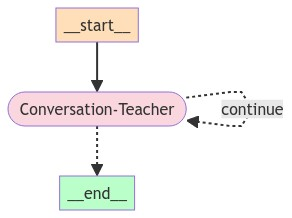

In [55]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [56]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="how do i say hello in french"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Conversation-Teacher': {'messages': [AIMessage(content='In French, you say "hello" as "Bonjour."\n\nFINAL ANSWER', response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 45, 'total_tokens': 60}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, name='Conversation-Teacher', id='run-d47ba17d-571e-46e8-9ed5-9e145c503d0e-0', usage_metadata={'input_tokens': 45, 'output_tokens': 15, 'total_tokens': 60})], 'sender': 'Conversation-Teacher'}}
----
